# 大作業
[MRI腦瘤判斷](https://www.kaggle.com/c/izcc-ailecture-1)

## Step1:準備資料
Tudo這裡好心，已經先準備好了

**建議! 把檔案放進drive裡面**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/izcc-ailecture-1.zip
!mkdir train_data
!mv /content/train_Brain_Tumor/train_Brain_Tumor train_data
!mv /content/train_Healthy/train_Healthy train_data


Archive:  /content/drive/MyDrive/izcc-ailecture-1.zip
  inflating: final_test_dataset/final_test_dataset/100_2.jpg  
  inflating: final_test_dataset/final_test_dataset/101_2.jpg  
  inflating: final_test_dataset/final_test_dataset/102_2.jpg  
  inflating: final_test_dataset/final_test_dataset/103_2.jpg  
  inflating: final_test_dataset/final_test_dataset/104_2.jpg  
  inflating: final_test_dataset/final_test_dataset/105_2.jpg  
  inflating: final_test_dataset/final_test_dataset/106_2.jpg  
  inflating: final_test_dataset/final_test_dataset/107_2.jpg  
  inflating: final_test_dataset/final_test_dataset/108_2.jpg  
  inflating: final_test_dataset/final_test_dataset/109_2.jpg  
  inflating: final_test_dataset/final_test_dataset/10_2.jpg  
  inflating: final_test_dataset/final_test_dataset/110_2.jpg  
  inflating: final_test_dataset/final_test_dataset/111_2.jpg  
  inflating: final_test_dataset/final_test_dataset/112_2.jpg  
  inflating: final_test_dataset/final_test_dataset/113_2.jpg  
  

In [3]:
import glob
import tqdm
import albumentations as A
ffs = glob.glob('/content/train_data/*/*')
import imageio
data = []
for f in ffs:
  if 'Brain_Tumor' in f:
    data.append([f, 1])
  else:
    data.append([f, 0])

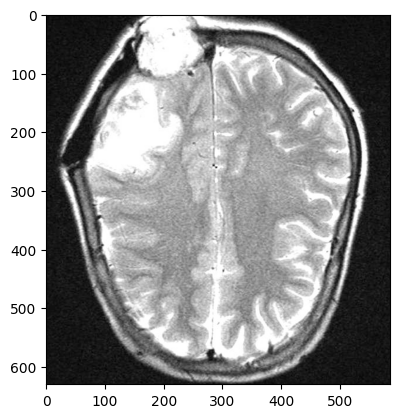

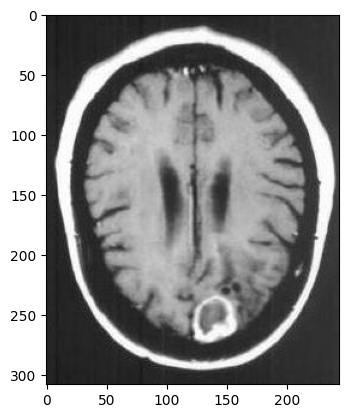

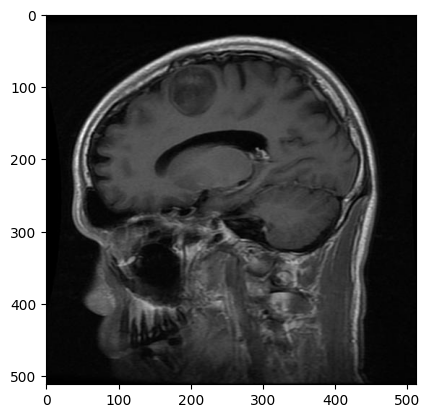

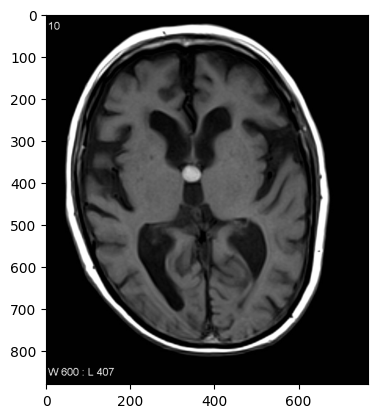

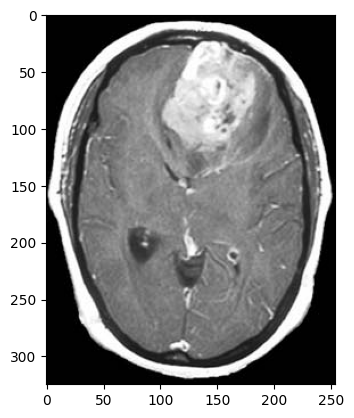

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
for i in range(5):
  image = Image.open(ffs[i])
  plt.imshow(image)
  plt.show()

In [5]:
transform = A.Compose([
    A.Resize(224, 224),
])

In [6]:
import imageio.v2 as imageio
import numpy as np
# 讀取和標記數據
ffs = glob.glob('train_data/*/*')
data = []
all_list = []
for f in tqdm.tqdm(ffs):
    im = imageio.imread(f)
    im = Image.fromarray(im).convert('L')
    im = np.array(im)


    if 'Brain_Tumor' in f:
        data.append([im, 1])
        all_list.append(1)
    else:
        data.append([im, 0])
        all_list.append(0)

np.bincount(all_list)

100%|██████████| 4062/4062 [00:10<00:00, 388.11it/s]


array([1879, 2183])

In [7]:
import numpy as np
import torch

def preprocess_image(image, transform, label, device):
    # 將圖像進行預處理
    im = transform(image=image)['image']
    # 將圖像擴展為 3 通道
    im = np.stack([im] * 3, axis=0)[None, ...]  # 1, 3, 224, 224
    # 將圖像正規化
    im = im / np.max(im)
    # 將 NumPy 陣列轉換為 PyTorch 張量
    im_d = torch.from_numpy(im).to(device).float()
    labels = torch.from_numpy(np.array([label])).to(device)

    return im_d, labels


In [8]:
import glob
import imageio.v2 as imageio
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from albumentations import Compose, Resize, Normalize
from albumentations.pytorch import ToTensorV2
from PIL import Image

class BrainTumorDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label = self.data[idx]
        image = imageio.imread(image_path)
        image = Image.fromarray(image).convert('L')
        image = np.array(image)

        # 複製單通道圖像以創建三個通道
        image = np.stack([image]*3, axis=-1)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, label

transform = Compose([
    Resize(224, 224),
    Normalize(mean=(0.5,), std=(0.5,)),
    ToTensorV2()
])

# 加載數據
ffs = glob.glob('train_data/*/*')
data = []
for f in ffs:
    if 'Brain_Tumor' in f:
        data.append([f, 1])
    else:
        data.append([f, 0])

# 創建數據集和數據加載器
dataset = BrainTumorDataset(data, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
!pip install onnx
def transfer_to_onnx(model,name):
  model.eval()
  example_input = torch.randn(1, 3, 224, 224)
  output_onnx_path = f"{name}.onnx"
  torch.onnx.export(model, example_input, output_onnx_path, verbose=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 79.7 MB/s eta 0:00:00
